# Applications of Spectral Procedure to a Regression Problem 

## Classical ML approach to regression 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Genero il dataset a partire da una funzione del tipo $e^{\alpha x}$ a cui aggiungo un rumore $\zeta$ gaussiano centrato in 0 e con larghezza $\sigma$

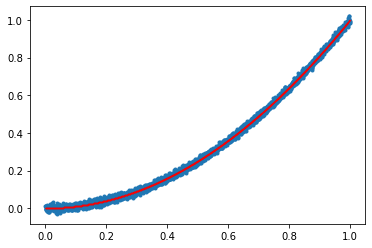

In [2]:
alpha = 2. 
sigma = 0.01
size = 3000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # rumore
t = x**alpha
y = t + z   # aggiungo rumore
data = np.c_[x,y,t]
np.random.shuffle(data)  # rimescolo l'ordine delle componeneti del dataset

plt.plot(data[:,0], data[:,1], marker='.', linestyle = '')
plt.plot(data[:,0], data[:,2], marker='.', linestyle='', color='red',markersize=0.5)
plt.show()

In [1]:
# prepare dataset
x_train = data[0:2399,0]
y_train = data[0:2399,1]

x_train = torch.from_numpy(x_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()

x_test = data[2399: ,0]
y_test = data[2399: ,1]

x_test = torch.from_numpy(x_test.reshape(-1,1)).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

NameError: name 'data' is not defined

#### Classical model 

Nel modello si addestrano stutti i pesi nello spazio diretto.

Il modello è un modello con due `hidden layer` ciascuno di dimensione 20, ognuno con una funzione di attivazione non lineare: in questo caso la funzione `elu`. L'lalgoritmo di ottimizzazione prevede l'impiego di un gradiente tipo `Adam optimization` calcolato sulla loss function `MSE`. Il `learning rate` è stato fissato a 0.03,



In [4]:
# Regression model
hidden_dim = 20

class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linearin = nn.Linear(1, hidden_dim)
        self.linearhid = nn.Linear(hidden_dim,hidden_dim)
        self.linearout = nn.Linear(hidden_dim,1)
    
    def forward(self,x):
        out = self.linearin(x)  # Prima trasformazione lineare imput
        out = self.linearhid(out) # Seconda trasformazione lineare
        out = F.elu(out)   # Filtro non lineare
        out = self.linearhid(out) # Terza trasformazione lineare
        out = F.elu(out)   #Filtro non lineare
        out = self.linearout(out)  # Ultima trasformazione e output
        return out
    
model = ClassicalModel()    

In [5]:
# Funzione per effettuare il training
def fit(epochs, lr, model, opt_func=torch.optim.Adam):
    
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    for k in range(epochs):
        y_pred = model(x_train) #forward feed
        #loss = torch.nn.MSELoss(y_pred,y_train)
        loss = F.mse_loss(y_pred,y_train) #calculate loss
        loss.backward() #calculate gradient
        optimizer.step() #update the weights
        optimizer.zero_grad() #clear out the gradients from the last step
        if (k+1) % int(epochs/3) == 0: 
            print('epoch {}, loss {} '.format(k+1, loss.item()))
            plt.cla()
            plt.plot(x_train.data.numpy(), y_train.data.numpy(), marker='.', linestyle='')
            plt.plot(x_train.data.numpy(), y_pred.data.numpy(), marker='.', linestyle='', color='red',markersize=0.5)
            plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
            plt.pause(0.1)

        plt.show()
        
    return model(x_train).detach().numpy()

#### Training 

Si esegue il training per 200 epoche


epoch 66, loss 0.0037464131601154804 


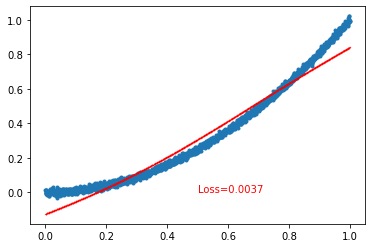

epoch 132, loss 0.00020185434550512582 


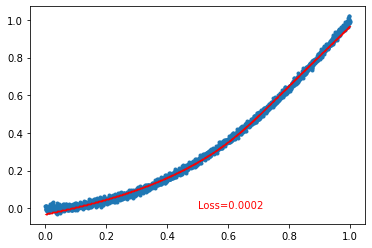

epoch 198, loss 0.00018117394938599318 


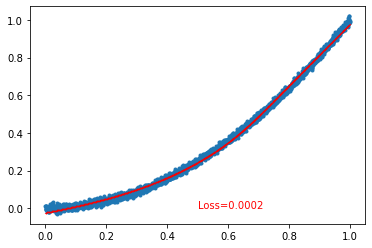

In [6]:
pred = fit(200, 0.01, model)

#### Test 

Il test viene effettuato sul dataset di test generato in origine

Final loss on test set: 0.0001756800338625908 


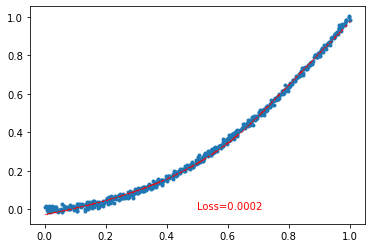

In [14]:
y_pred = model(x_test)
loss = F.mse_loss(y_pred,y_test)

print('Final loss on test set: {} '.format(loss.item()))
plt.cla()
plt.plot(x_test.data.numpy(), y_test.data.numpy(), marker='.', linestyle='')
plt.plot(x_test.data.numpy(), y_pred.data.numpy(), marker='.', linestyle='', color='red',markersize=0.5)
plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})

plt.show()

## Spectral approach to regression 

In [18]:
import numpy as np
import tensorflow as tf
from SpectralLayer import Spectral
import matplotlib.pyplot as plt

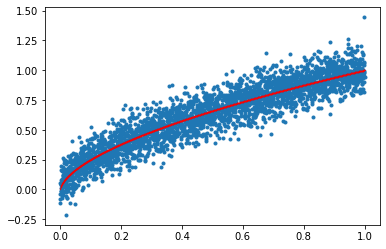

In [29]:
alpha = 0.6 
sigma = 0.1
size = 3000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  #noise
t = x**alpha
y = t + z   #add noise
data = np.c_[x,y,t]
np.random.shuffle(data)  # rimescolo l'ordine delle componeneti del dataset


plt.plot(data[:,0], data[:,1], marker='.', linestyle = '')
plt.plot(data[:,0], data[:,2], marker='.', linestyle='', color='red',markersize=0.5)
plt.show()

In [30]:
x_train = data[0:2399,0]
y_train = data[0:2399,1]

x_test = data[2399: ,0]
y_test = data[2399: ,1]



#### Spectral model 

Nel modello si addestrano solo gli autovalori, lasciando gli autovettori fissati, senza considerare bias.

Il modello è un modello con due `hidden layer` ciascuno di dimensione 20, ognuno con una funzione di attivazione non lineare: in questo caso la funzione `elu`. L'lalgoritmo di ottimizzazione prevede l'impiego di un gradiente tipo `Adam optimization` calcolato sulla loss function `MSE`. Il `learning rate` è stato fissato a 0.03, 



In [31]:
#This configurations trains only the eigenvalues
spectral_config={
    'is_base_trainable' : False,
    'is_diag_start_trainable' : True,
    'is_diag_end_trainable' : True,
    'use_bias' : False
}

#Build a model of 3 spectral layers according to the dimensions given previously
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(1), dtype='float32'))
model.add(Spectral(20, **spectral_config, activation='elu'))
model.add(Spectral(20, **spectral_config, activation='elu'))
model.add(Spectral(1, **spectral_config))
opt = tf.keras.optimizers.Adam(learning_rate=0.03)


model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_6 (ModuleWra  (None, 20)               41        
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 20)               440       
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 1)                41        
 pper)                                                           
                                                                 
Total params: 522
Trainable params: 82
Non-trainable params: 440
_________________________________________________________________


#### Training 
Eseguo il training del modello aggiungendo una funzione `EarlyStopping` interrompendo il training nel momento in cui la loss function non dovesse decrescere per più di 5 epoche

In [32]:
from keras.callbacks import EarlyStopping
epochs=100
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)  # Interrrompo il processo quando la loss non decresce più
history = model.fit(x_train, y_train, batch_size=1, verbose=2, epochs=epochs, callbacks=[es])



Epoch 1/100
2399/2399 - 2s - loss: 0.0163 - accuracy: 0.0000e+00 - 2s/epoch - 648us/step
Epoch 2/100
2399/2399 - 1s - loss: 0.0128 - accuracy: 0.0000e+00 - 1s/epoch - 507us/step
Epoch 3/100
2399/2399 - 1s - loss: 0.0127 - accuracy: 0.0000e+00 - 1s/epoch - 513us/step
Epoch 4/100
2399/2399 - 1s - loss: 0.0124 - accuracy: 0.0000e+00 - 1s/epoch - 510us/step
Epoch 5/100
2399/2399 - 1s - loss: 0.0127 - accuracy: 0.0000e+00 - 1s/epoch - 511us/step
Epoch 6/100
2399/2399 - 1s - loss: 0.0122 - accuracy: 0.0000e+00 - 1s/epoch - 505us/step
Epoch 7/100
2399/2399 - 1s - loss: 0.0123 - accuracy: 0.0000e+00 - 1s/epoch - 510us/step
Epoch 8/100
2399/2399 - 1s - loss: 0.0123 - accuracy: 0.0000e+00 - 1s/epoch - 519us/step
Epoch 9/100
2399/2399 - 1s - loss: 0.0121 - accuracy: 0.0000e+00 - 1s/epoch - 511us/step
Epoch 10/100
2399/2399 - 1s - loss: 0.0123 - accuracy: 0.0000e+00 - 1s/epoch - 507us/step
Epoch 11/100
2399/2399 - 1s - loss: 0.0116 - accuracy: 0.0000e+00 - 1s/epoch - 507us/step
Epoch 12/100
2399/2

#### Test 

Il test viene effettuato sul dataset di test generato in origine

601/601 [==============================] - 1s 628us/step - loss: 0.0104 - accuracy: 0.0000e+00


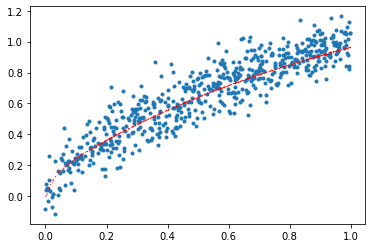

In [33]:
tested = model.evaluate(x_test, y_test, batch_size=1, verbose=1)
predicted = model.predict(x_test)


plt.plot(x_test, y_test, marker='.', linestyle='')
plt.plot(x_test, predicted, marker='.', linestyle='', color='red',markersize=0.5)
plt.show()